In [1]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from kmeans import KMeans
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import cv2
import pandas as pd
from collections import Counter
from IPython.display import display



# Introduction

The BraTS (Brain Tumour Segmentation) dataset consists of multi-modal MRI images of brain tumours, specifically gliomas, a subtype which represents about 80% of all malignant brain tumours, and the corresponding segmentation masks. The dataset is updated yearly in the context of the MICCAI (Medical Image Computing and Computer-Assisted Intervention) conference. The latest data available is from BraTS2023, but we chose to work with BraTS2020. This was done because the size of the 2020 dataset, at 369 patients, is already enough to make the computations needed very lenghty on the systems at our disposal. BraTS2021 and BraTS2022 comprise data from more than 2000 patients while BraTS2023 goes up to 4500 patients, which were computationally unfeasible with the computers at hand.

The BraTS2020 dataset is made up of routine clinically-acquired pre-operative multimodal MRI of glioblastoma and lower-grade glioma with accompanying ground truth labels by board-certified neuroradiologists. The scans have been taken at 19 different insitutions and come in the NIfTI format (.nii.gz), a standard format for MRI images. They are multi-modal in the sense that, for each of the 369 patients, 4 different MRI configurations have been used:

a) native (T1) and b) post-contrast T1-weighted (T1Gd)

c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

T1 and T2 refer to longitudinal and transversal relaxing time respectively and are the two main focus of MRI imaging. Through the differences in the longitudinal and transversal relaxing time one can distinguish a certain type of biological tissue from another. In T1 scans, white matter appears brilliant, grey matter appears grey and liquids and lesions appear darker. T1Gd is when a T1 scan is used together with a Gadolinium-based contrast which, being absorbed by those tissues with a compromised blood-brain barrier, allows to easily distinguish the active part of the tumour (called enhancing tumour). In T2 scans, on the countrary, liquid and lesions are brilliant and white matter is dark. T2-FLAIR is a technique which allows to darken the cerebrospinal fluid (CSF) making it easier to distinguish the edema due to the tumour.

Data from a mix of these modalities allows for a correct segmentation of the tumour tissue and is fundamental for the practical work of neurosurgeons and neuroradiologists, which need to understand the geometry and composition of the tumour. This kind of segmentation task is made more difficult by the heterogeneity of gliomas and the different tissues making up a tumour. Three different patological tissues are considered here: A) Enhancing Tumour Core, which represents the active part of the disease and has label 4, B) Necrotic and Non-Enhancing Tumour Core, which are inactive parts of the tumour and are labelled 1, and C) Peritumoral Edema, which is fluid that accumulates around the tumour and is labelled with 2. The fourth and last label, 0, is used for everything else (the rest of the brain with all its structures and CSF).

# Loading the Scans with Nibabel

To work with NIfTI (Neuroimaging Informatics Technology Initiative) data one can use the Nibabel library, which has been created to easily access and manipulate neurological data in various medical formats. We use it to extract the scans voxel values into a NumPy array, allowing us to work with more familiar objects afterwards.

Each set of scans has 155 slices with 240x240 pixels per slice (so we have 240x240x155 voxels per modality). We have 4 modalities per patient and 369 patients in total. In the cell below we demonstrate how to load the modalities from patient 355. We also rescale the images as this format can have voxel intensity values which vary from 0 to a few thousands and we want to keep all modalities in the same scale so that the model can confront slices without any bias due only to the differing scales.

In [2]:
# Directory di Chiara
#TRAIN_DATASET_PATH = "/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

#Directory di Gianluca
TRAIN_DATASET_PATH= "C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Carica il file .nii come array NumPy sfruttando nibabel
#test_image_flair_ = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii")
#print(test_image_flair_.header)

test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()

# Informazioni sull'immagine
print("FLAIR Shape: ", test_image_flair.shape)
print("FLAIR Dtype: ", test_image_flair.dtype)
print("FLAIR Min: ", test_image_flair.min())
print("FLAIR Max: ", test_image_flair.max())

# Rescaling voxel-wise a [0, 1]
test_image_flair = (test_image_flair - np.min(test_image_flair)) / (np.max(test_image_flair) - np.min(test_image_flair))

# Verifica
print("Rescaled min:", test_image_flair.min())
print("Rescaled max:", test_image_flair.max(), "\n")

#Carichiamo e riscaliamo alla stessa maniera anche le altre modalità
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
print("T1 Shape: ", test_image_t1.shape)
print("T1 Min: ", test_image_t1.min())
print("T1 Max: ", test_image_t1.max(), "\n")

test_image_t1 = (test_image_t1 - np.min(test_image_t1)) / (np.max(test_image_t1) - np.min(test_image_t1))

test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
print("T1ce Shape: ", test_image_t1ce.shape)
print("T1ce Min: ", test_image_t1ce.min())
print("T1ce Max: ", test_image_t1ce.max(), "\n")

test_image_t1ce = (test_image_t1ce - np.min(test_image_t1ce)) / (np.max(test_image_t1ce) - np.min(test_image_t1ce))

test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
print("T2 Shape: ", test_image_t2.shape)
print("T2 Min: ", test_image_t2.min())
print("T2 Max: ", test_image_t2.max(), "\n")

test_image_t2 = (test_image_t2 - np.min(test_image_t2)) / (np.max(test_image_t2) - np.min(test_image_t2))

# La maschera di segmentazione non va riscalata, in quanto i valori che assume sono 0, 1, 2 e 4 a seconda del tipo di tessuto
# 0 = background, 1 = edema, 2 = non-enhancing tumour, 4 = enhancing tumour
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
print("Mask Shape: ", test_image_seg.shape)
print("Mask Min: ", test_image_seg.min())
print("Mask Max: ", test_image_seg.max())

FLAIR Shape:  (240, 240, 155)
FLAIR Dtype:  float64
FLAIR Min:  0.0
FLAIR Max:  1854.603271484375
Rescaled min: 0.0
Rescaled max: 1.0 

T1 Shape:  (240, 240, 155)
T1 Min:  0.0
T1 Max:  1717.368408203125 

T1ce Shape:  (240, 240, 155)
T1ce Min:  0.0
T1ce Max:  8309.0 

T2 Shape:  (240, 240, 155)
T2 Min:  0.0
T2 Max:  5822.11474609375 

Mask Shape:  (240, 240, 155)
Mask Min:  0.0
Mask Max:  4.0


# Data Visualization

In the following cell a dynamic visualization is built so that one can check how the different scans and the corresponding mask evolves slice by slice. In the mask, black represents healthy tissue (therefore it shows as the background for the tumoral tissue), green is the Necrotic and Non-Enhancing tissue, yellow is the Edema while light blue is used for the Enhancing Tumour Core. The visualization is again using the data we already loaded relative to patient 355.

In [3]:
# === Colori per la maschera ===
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)

# === Visualizzazione dinamica ===
def show_slice(slice_idx):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # MRI modalities
    titles = ['T1', 'T1ce', 'T2', 'FLAIR']
    volumes = [test_image_t1, test_image_t1ce, test_image_t2, test_image_flair]

    for i in range(4):
        axs[i // 3, i % 3].imshow(volumes[i][:, :, slice_idx], cmap='gray')
        axs[i // 3, i % 3].set_title(titles[i])
        axs[i // 3, i % 3].axis('off')

    # Mask
    axs[1, 1].imshow(test_image_seg[:, :, slice_idx], cmap=cmap_mask, norm=norm)
    axs[1, 1].set_title('Mask')
    axs[1, 1].axis('off')

    # Legend
    axs[1, 2].axis('off')
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
    axs[1, 2].legend(handles=patches, loc='center')

    plt.tight_layout()
    plt.show()

# === Interfaccia interattiva ===
interact(
    show_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_t1.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_slice(slice_idx)>

The transverse view is not the only useful visualization of MRI scans, frontal and sagittal angles are other useful options. Below is an example of the same modality, T1, shown by slicing over the other dimensions.

In [4]:
# Visualizzazione delle viste trasversa, frontale e sagittale
def show_views(slice_idx):
    fig = plt.figure(figsize=(12, 5))

    H, W, D = test_image_t1ce.shape  # 240, 240, 155
    
    # Transverse View
    z_idx = min(slice_idx, D - 1) # Assicura di non eccedere l'indice
    ax1 = fig.add_subplot(1, 3, 1)
    img1 = test_image_t1ce[:, :, z_idx]
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(f'T1 - Transverse (Z={z_idx})')
    ax1.axis('off')

    # Frontal View 
    y_idx = min(slice_idx, W - 1)
    ax2 = fig.add_subplot(1, 3, 2)
    img2 = rotate(test_image_t1ce[:, y_idx, :], 90, reshape=True)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(f'T1 - Frontal (Y={y_idx})')
    ax2.axis('off')

    # Sagittal View
    x_idx = min(slice_idx, H - 1)
    ax3 = fig.add_subplot(1, 3, 3)
    img3 = rotate(test_image_t1ce[x_idx, :, :], 90, reshape=True)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(f'T1 - Sagittal (X={x_idx})')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Slider interattivo
max_index = max(test_image_t1ce.shape)  # 240
interact(
    show_views,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=max_index - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)


interactive(children=(IntSlider(value=95, description='Slice:', max=239), Output()), _dom_classes=('widget-int…

<function __main__.show_views(slice_idx)>

In [5]:
# === Mappa colori e normalizzazione (adatta a BraTS ad esempio)
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR/NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], len(colors))

# === Funzione dinamica
def show_segmented_slice(slice_idx):
    # Isola ogni classe come maschera separata (usando NaN per trasparenza)
    seg_0 = test_image_seg.copy()
    seg_0[seg_0 != 0] = np.nan
    
    seg_1 = test_image_seg.copy()
    seg_1[seg_1 != 1] = np.nan
    
    seg_2 = test_image_seg.copy()
    seg_2[seg_2 != 2] = np.nan
    
    seg_4 = test_image_seg.copy()
    seg_4[seg_4 != 4] = np.nan

    # Legenda personalizzata
    legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

    # Plot
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].imshow(test_image_seg[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[0].set_title('Original Segmentation')
    ax[0].legend(handles=legend, loc='lower left')
    ax[0].axis('off')

    ax[1].imshow(seg_0[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[1].set_title('Class 0 (Background)')
    ax[1].axis('off')

    ax[2].imshow(seg_1[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[2].set_title('Class 1 (NCR/NET)')
    ax[2].axis('off')

    ax[3].imshow(seg_2[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[3].set_title('Class 2 (Edema)')
    ax[3].axis('off')

    ax[4].imshow(seg_4[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[4].set_title('Class 4 (Enhancing Tumor)')
    ax[4].axis('off')

    plt.tight_layout()
    plt.show()

# === Slider interattivo
interact(
    show_segmented_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_seg.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_segmented_slice(slice_idx)>

# K-Means

Image segmentation is a kind of task in which Machine Learning has shown to be vastly superior to older algorithmical methods. The task at hand, due to the heterogeneous nature of the segmentation of MRI images, is yet another case in which modern deep learning techniques outperform other types of techniques. We still decided to try two non-ML segmentation methods, K-Means and Non-Negative Matrix Factorization (NMF), to obtain a baseline level performance for comparison with the U-Net architecture that will be applied later on in the project.

Our application of these methods is barebones. While researchers trying to apply these methodologies would often use them in combination with a series of filters, edge detectors, thresholding methods that could increase the performances (as well as requiring a lot of manual labor and heuristics), here we limit ourselves to applying this techniques directly.

In very simple segmentation tasks, using non-ML methods can still sometimes be useful, especially when there isn't enough data to train complex models on and/or when the segmentation is so simple that one can prefer techniques which are computationally much cheaper. In the context of medical imaging however, given the high precision needed to obtain actually usable software, classical techniques don't really find any application if not in pre- or post-processing of other algorithms input/output.

To apply the K-Means algorithm, we extract a certain slice (corresponding to a mask showing every kind of tumoral tissue) from a patient data for every modality. For example, the slice 95 from patient 355 for T1, T1ce, T2 and T2-FLAIR. We then unite these 4 slices into a single 240x240x4 array which is reshaped into a 57600x4 array. This is necessary because K-Means works on a 2D array representing the observations and corresponding features. We then visualize the clusters the algorithm found.

The result strongly depends on the specific initialization. If the initial centroids all fall into the background section, than K-Means will cluster the whole image as a single cluster. If the initialization is more varied, we obtain more varied results. Because of the non-semantic nature of K-Means, some of the divisions it finds, like the one between CSF and healthy brain, while anatomically correct, are not of interest for the task at hand. Relative to the tumoral tissue, while it doesn't do a perfect job and while it can't always distinguish ET from ED, it is sometimes able to segment the different parts of the disease with a moderate level of accuracy.

Shape of X: (240, 240, 4)
Shape of X_reshaped: (57600, 4)


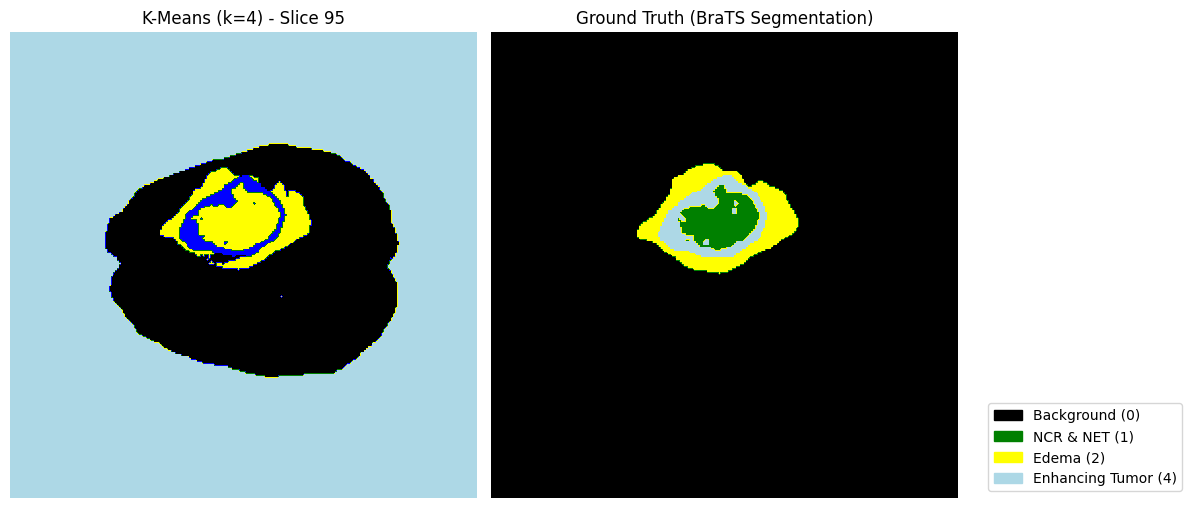

In [6]:
#Parametri
slice_idx = 95
k = 4  # Numero di cluster per K-Means
 
#Slice delle differenti modalità
flair_slice = test_image_flair[:, :, slice_idx]
t1_slice = test_image_t1[:, :, slice_idx]
t1ce_slice = test_image_t1ce[:, :, slice_idx]
t2_slice = test_image_t2[:, :, slice_idx]
mask_slice = test_image_seg[:, :, slice_idx]
 
# Le slice vengono congiunte attraverso il metodo stack, che unisce più array lungo una
# nuova dimensione. Con un reshape, ogni pixel viene rappresentato da un vettore di 4 valori (uno per ogni modalità)

X = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=-1) #240x240x4
print("Shape of X:", X.shape)
X_reshaped = X.reshape((-1, 4)).astype(np.float32) #240x240=57600 -> 57600x4, KMeans lavora su un array 2D
print("Shape of X_reshaped:", X_reshaped.shape)

# Applica K-Means
km = KMeans(n_clus=k)
km.fit(X_reshaped)
clusters = km.getClusters()
 
# Ritorniamo alla dimensione 240x240
segmented_image = clusters.reshape(flair_slice.shape) 
 
# Colori clusters
cmap_kmeans = ListedColormap(['black', 'blue', 'green', 'yellow', 'lightblue'])
 
# Colori maschera
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)
 
# Visualizzazione
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
axs[0].imshow(segmented_image, cmap=cmap_kmeans)
axs[0].set_title(f'K-Means (k={k}) - Slice {slice_idx}')
axs[0].axis('off')
 
axs[1].imshow(mask_slice, cmap=cmap_mask, norm=norm)
axs[1].set_title('Ground Truth (BraTS Segmentation)')
axs[1].axis('off')
 
# Legenda della maschera reale
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
axs[1].legend(handles=patches, loc='lower left', bbox_to_anchor=(1.05, 0))
 
plt.tight_layout()
plt.show()

As remarked above, K-Means is non-semantic. It is an unsupervised technique. This means that the clusters found need to be manually associated, in an heuristic manner, to ground truth labels. To make this association we take advantage of the hungarian algorithm. This then enables us to calculate the specificity, precision and Dice Coefficient. We also define a function allowing us to calculate the symmetric Hausdorff distance. These metrics work in tandem, in the sense that even having a good overlap between the ground truth label and the prediction doesn't guarantee that a section of the ground truth, small in area, may lie "far" from the predicted mask. The hausdorff distance, here measured in pixels, allows us to check the "maximum minimum" distance between the two masks, informing us in the case that a section of the mask in not being correctly classified by the model even if the total overlap is high.

In [7]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def map_clusters_to_classes_hungarian(cluster_labels, true_labels, n_classes=4):
    """
    Maps K-Means clusters to ground truth classes using Hungarian assignment.
    
    Args:
        cluster_labels (np.ndarray): Cluster indices from K-Means, shape (H,W)
        true_labels   (np.ndarray): Ground truth segmentation, shape (H,W)
        n_classes (int): Number of target classes (BraTS: 4 after remap)
    
    Returns:
        mapped_labels (np.ndarray): Cluster labels remapped to GT classes
        true_seg_processed (np.ndarray): GT segmentation with labels remapped 4→3
    """
    # Preprocess ground truth: remap 4 -> 3 (BraTS enhancing tumor)
    true_seg_processed = true_labels.copy()
    true_seg_processed[true_seg_processed == 4] = 3

    # Flatten
    true_flat = true_seg_processed.flatten()
    cluster_flat = cluster_labels.flatten()

    # Build confusion matrix (rows = true, cols = clusters)
    conf = confusion_matrix(true_flat, cluster_flat, labels=range(n_classes))

    # Hungarian algorithm: maximize correct assignment (so we minimize -conf)
    row_ind, col_ind = linear_sum_assignment(-conf)

    # Build mapping: cluster → true class
    mapping = {col: row for row, col in zip(row_ind, col_ind)}

    # Remap clusters to semantic labels
    mapped_flat = np.vectorize(mapping.get)(cluster_flat)
    mapped_labels = mapped_flat.reshape(cluster_labels.shape)

    return mapped_labels, true_seg_processed


In [9]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(mask1, mask2):
    """
    Computes the symmetric Hausdorff Distance between two binary masks.
    """
    # Extract coordinates of foreground pixels
    coords1 = np.argwhere(mask1)
    coords2 = np.argwhere(mask2)

    if len(coords1) == 0 or len(coords2) == 0:
        return np.nan  # undefined if either mask empty

    # Directed HD in both directions
    hd1 = directed_hausdorff(coords1, coords2)[0]
    hd2 = directed_hausdorff(coords2, coords1)[0]

    return max(hd1, hd2)


In [10]:
from scipy.spatial.distance import cdist

def hausdorff95(mask1, mask2): # Too computationally intensive, not used
    """
    Computes the 95th percentile Hausdorff Distance between two binary masks.
    """
    # Extract coordinates of foreground voxels
    coords1 = np.argwhere(mask1)
    coords2 = np.argwhere(mask2)

    if len(coords1) == 0 or len(coords2) == 0:
        return np.nan  # undefined if either is empty

    # Compute all pairwise distances
    dists = cdist(coords1, coords2, metric='euclidean')

    # Directed distances: min distance from each point in one set to the other
    dists1 = np.min(dists, axis=1)
    dists2 = np.min(dists, axis=0)

    # Take 95th percentile of both and max them
    hd95 = max(np.percentile(dists1, 95), np.percentile(dists2, 95))
    return hd95


K-Means Evaluation Metrics:
Background:
  Dice = 0.8857
  Sensitivity = 0.7948
  Precision = 1.0000
  Hausdorff Distance = 58.5235

Necrotic/Core:
  Dice = 0.5054
  Sensitivity = 1.0000
  Precision = 0.3381
  Hausdorff Distance = 30.5287

Edema:
  Dice = 0.0833
  Sensitivity = 0.3432
  Precision = 0.0474
  Hausdorff Distance = 67.2012

Enhancing:
  Dice = 0.0000
  Sensitivity = 0.0000
  Precision = 0.0000
  Hausdorff Distance = 73.7835



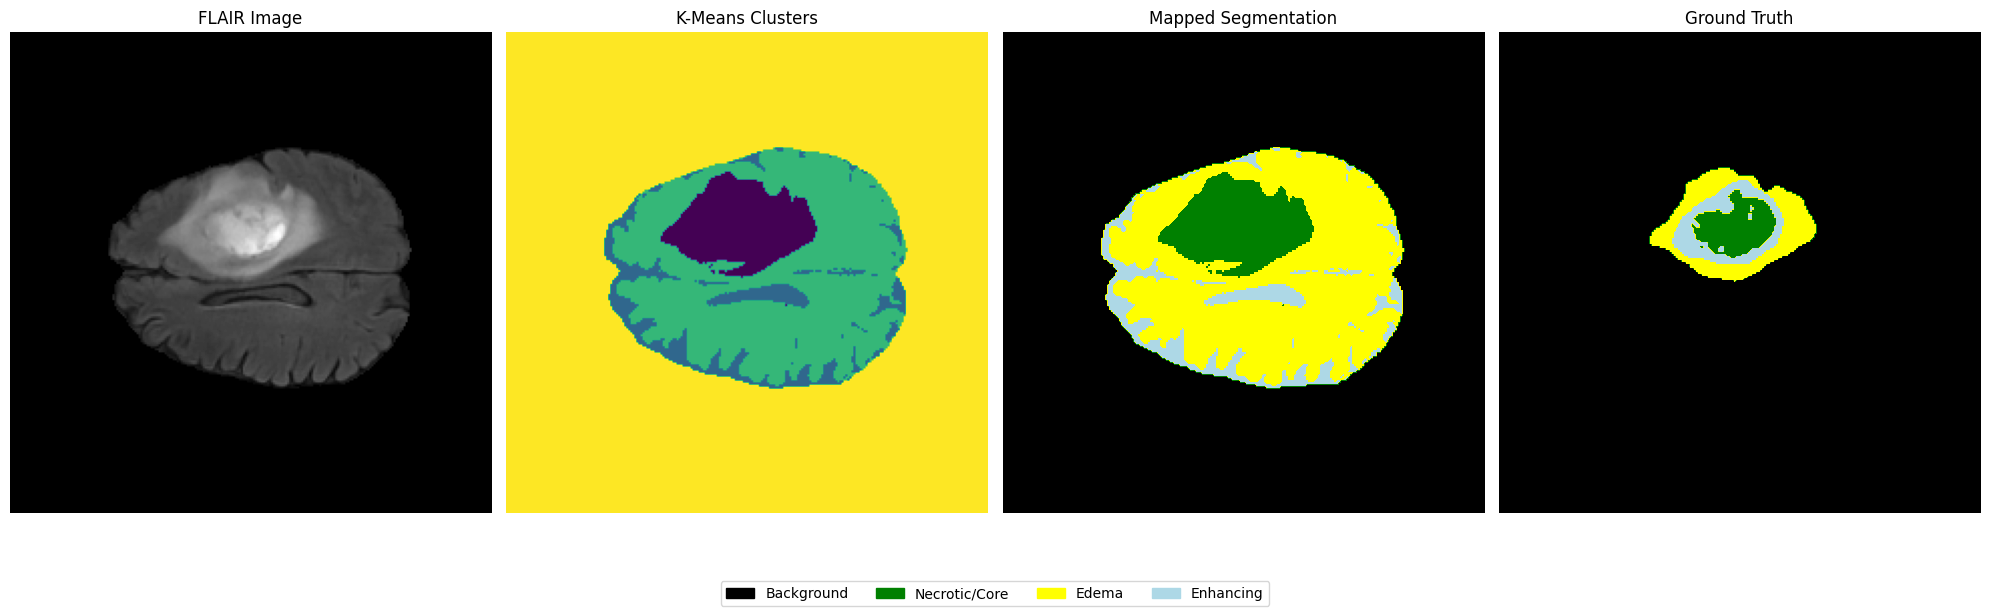

In [11]:
def compute_kmeans_metrics(patient_id, slice_idx, k=4):
    """Computes segmentation metrics for K-Means on a given slice"""
    # Load and preprocess data
    case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)
    
    # Load all modalities
    flair = nib.load(os.path.join(case_path, f"{patient_id}_flair.nii")).get_fdata()[:, :, slice_idx]
    t1 = nib.load(os.path.join(case_path, f"{patient_id}_t1.nii")).get_fdata()[:, :, slice_idx]
    t1ce = nib.load(os.path.join(case_path, f"{patient_id}_t1ce.nii")).get_fdata()[:, :, slice_idx]
    t2 = nib.load(os.path.join(case_path, f"{patient_id}_t2.nii")).get_fdata()[:, :, slice_idx]
    seg = nib.load(os.path.join(case_path, f"{patient_id}_seg.nii")).get_fdata()[:, :, slice_idx]
    
    # Rescale each modality
    flair = (flair - np.min(flair)) / (np.max(flair) - np.min(flair))
    t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1))
    t1ce = (t1ce - np.min(t1ce)) / (np.max(t1ce) - np.min(t1ce))
    t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2))
    
    # Prepare input data
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    X_reshaped = X.reshape((-1, 4))
    
    # Apply K-Means
    km = KMeans(n_clus=k)
    km.fit(X_reshaped.astype(np.float32))
    clusters = km.getClusters().reshape(flair.shape)
    
    # Map clusters to classes
    mapped_seg, true_seg = map_clusters_to_classes_hungarian(clusters, seg)
    
    # Compute metrics
    metrics = {}
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    
    for class_id, class_name in enumerate(class_names):
        true_mask = (true_seg == class_id)
        pred_mask = (mapped_seg == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_mask, pred_mask).sum()
        dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum() + 1e-7)
        
        # Sensitivity (Recall)
        tp = np.logical_and(true_mask, pred_mask).sum()
        fn = np.logical_and(true_mask, ~pred_mask).sum()
        sensitivity = tp / (tp + fn + 1e-7)
        
        # Precision
        fp = np.logical_and(~true_mask, pred_mask).sum()
        precision = tp / (tp + fp + 1e-7)
        
        # Hausdorff Distance
        hd = hausdorff_distance(true_mask, pred_mask)
        #hd95 = hausdorff95(true_mask, pred_mask)

        metrics[class_name] = {
            'dice': dice,
            'sensitivity': sensitivity,
            'precision': precision,
            'hausdorff': hd
            #'hausdorff95': hd95
        }
    
    # Return all necessary data including the FLAIR image for visualization
    return metrics, clusters, mapped_seg, true_seg, flair

# Example usage for patient 355, slice 95
patient_id = "BraTS20_Training_355"
slice_idx = 95

# Compute metrics and get results
metrics, clusters, mapped_seg, true_seg, flair_img = compute_kmeans_metrics(patient_id, slice_idx)

# Print metrics
print("K-Means Evaluation Metrics:")
for class_name, scores in metrics.items():
    print(f"{class_name}:")
    print(f"  Dice = {scores['dice']:.4f}")
    print(f"  Sensitivity = {scores['sensitivity']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}")
    print(f"  Hausdorff Distance = {scores['hausdorff']:.4f}\n")
    #print(f"  Hausdorff95 Distance = {scores['hausdorff95']:.4f}\n")

# Visual comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Original MRI (FLAIR)
axs[0].imshow(flair_img, cmap="gray")
axs[0].set_title('FLAIR Image')
axs[0].axis('off')

# K-Means clusters
axs[1].imshow(clusters, cmap="viridis")
axs[1].set_title('K-Means Clusters')
axs[1].axis('off')

# Mapped segmentation
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
cmap_mapped = ListedColormap(colors)
axs[2].imshow(mapped_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[2].set_title('Mapped Segmentation')
axs[2].axis('off')

# Ground Truth
axs[3].imshow(true_seg, cmap=cmap_mapped, 
             norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[3].set_title('Ground Truth')
axs[3].axis('off')

# Add legend
patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
plt.figlegend(patches, class_names, loc='lower center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for legend
plt.show()

# Non-Negative Matrix Factorization

In this section we repeat a process that is completely analogous to the previous K-Means section. We fit a "classical" model, namely Non-Negative Matrix Factorization, on an example slice to obtain a "classical" baseline perfomance level. The same metrics are used. We can see that NMF performs worse than K-Means, with much more confused clusters and consequently mostly worse metrics (with the exception of the background).

In [12]:
def map_nmf_to_classes_hungarian(component_labels, true_labels, n_classes=4):
    """
    Maps NMF component labels to ground truth classes using Hungarian assignment.
    
    Args:
        component_labels (np.ndarray): Labels from argmax(W), shape (H,W)
        true_labels (np.ndarray): Ground truth segmentation, shape (H,W)
        n_classes (int): Number of semantic classes (BraTS: 4 after remap)
    
    Returns:
        mapped_labels (np.ndarray): Component labels remapped to GT classes
        true_seg_processed (np.ndarray): GT segmentation with 4→3 remap
    """
    # Preprocess ground truth: remap 4 → 3 (enhancing tumor)
    true_seg_processed = true_labels.copy()
    true_seg_processed[true_seg_processed == 4] = 3

    # Flatten
    true_flat = true_seg_processed.flatten()
    comp_flat = component_labels.flatten()

    # Build confusion matrix (rows = GT classes, cols = NMF comps)
    conf = confusion_matrix(true_flat, comp_flat, 
                            labels=range(n_classes))

    # Hungarian assignment: maximize overlap
    row_ind, col_ind = linear_sum_assignment(-conf)

    # Build mapping comp → class
    mapping = {col: row for row, col in zip(row_ind, col_ind)}

    # Apply mapping
    mapped_flat = np.vectorize(mapping.get)(comp_flat)
    mapped_labels = mapped_flat.reshape(component_labels.shape)

    return mapped_labels, true_seg_processed


NMF Evaluation Metrics:
Background:
  Dice = 0.9291
  Sensitivity = 0.8700
  Precision = 0.9968
  Hausdorff Distance = 9.2195

Necrotic/Core:
  Dice = 0.0072
  Sensitivity = 0.0178
  Precision = 0.0045
  Hausdorff Distance = 77.7817

Edema:
  Dice = 0.6432
  Sensitivity = 0.8273
  Precision = 0.5262
  Hausdorff Distance = 19.7231

Enhancing:
  Dice = 0.2403
  Sensitivity = 0.8020
  Precision = 0.1413
  Hausdorff Distance = 73.7835



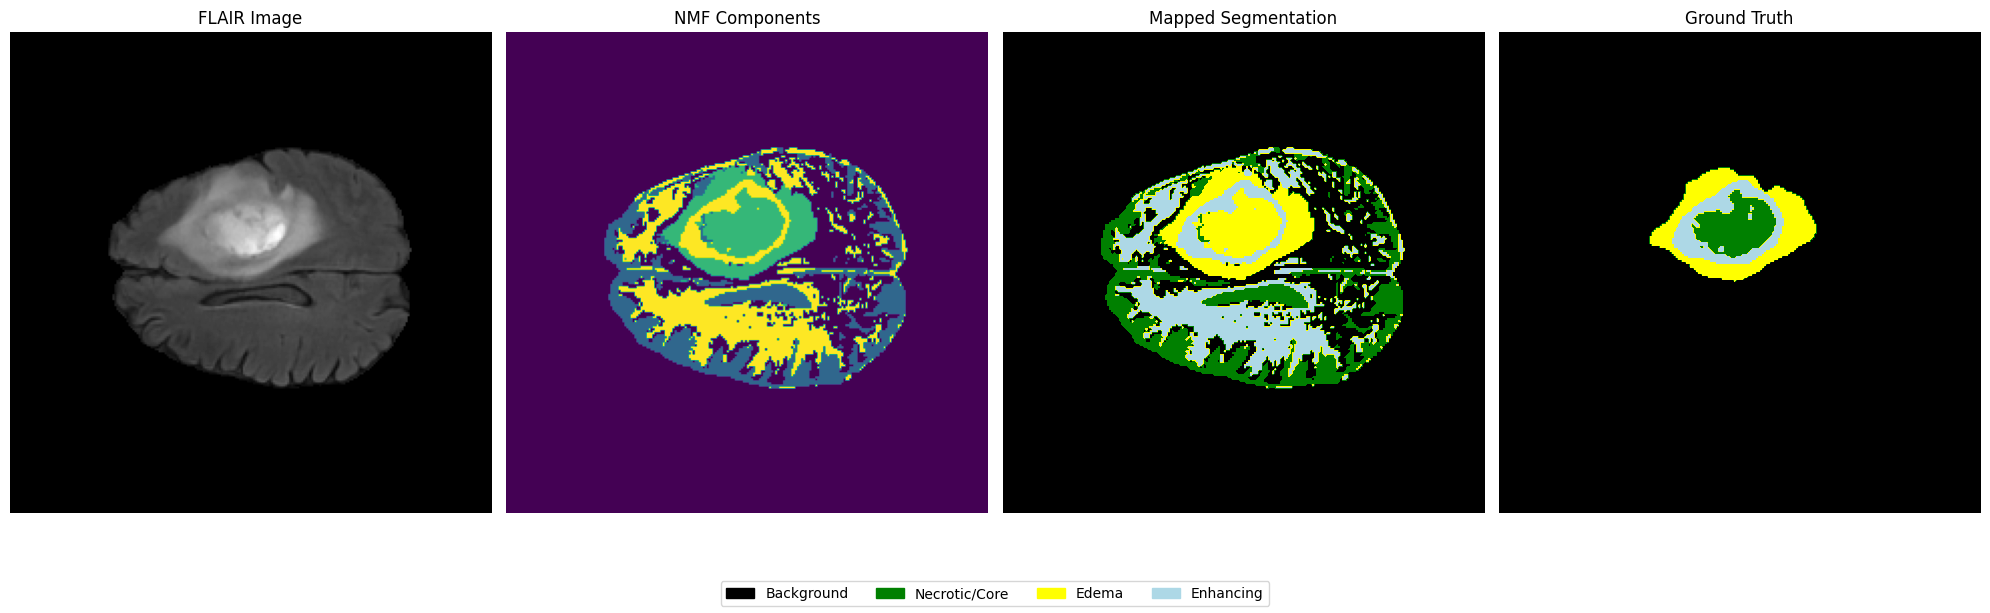

In [13]:
from sklearn.decomposition import NMF

def compute_nmf_metrics(patient_id, slice_idx, n_components=4):
    """Computes segmentation metrics for NMF on a given slice"""
    # Load and preprocess data
    case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)
    
    # Load all modalities
    flair = nib.load(os.path.join(case_path, f"{patient_id}_flair.nii")).get_fdata()[:, :, slice_idx]
    t1 = nib.load(os.path.join(case_path, f"{patient_id}_t1.nii")).get_fdata()[:, :, slice_idx]
    t1ce = nib.load(os.path.join(case_path, f"{patient_id}_t1ce.nii")).get_fdata()[:, :, slice_idx]
    t2 = nib.load(os.path.join(case_path, f"{patient_id}_t2.nii")).get_fdata()[:, :, slice_idx]
    seg = nib.load(os.path.join(case_path, f"{patient_id}_seg.nii")).get_fdata()[:, :, slice_idx]
    
    # Rescale each modality
    flair = (flair - np.min(flair)) / (np.max(flair) - np.min(flair) + 1e-7)
    t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1) + 1e-7)
    t1ce = (t1ce - np.min(t1ce)) / (np.max(t1ce) - np.min(t1ce) + 1e-7)
    t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2) + 1e-7)
    
    # Prepare input data
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    X_reshaped = X.reshape((-1, 4))
    
    # Apply NMF
    nmf_model = NMF(n_components=n_components, init='nndsvda', max_iter=200, random_state=42)
    W = nmf_model.fit_transform(np.maximum(X_reshaped, 0))
    components = np.argmax(W, axis=1).reshape(flair.shape)
    
    # Map components to classes
    mapped_seg, true_seg = map_nmf_to_classes_hungarian(components, seg)
    
    # Compute metrics
    metrics = {}
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    
    for class_id, class_name in enumerate(class_names):
        true_mask = (true_seg == class_id)
        pred_mask = (mapped_seg == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_mask, pred_mask).sum()
        dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum() + 1e-7)
        
        # Sensitivity (Recall)
        tp = np.logical_and(true_mask, pred_mask).sum()
        fn = np.logical_and(true_mask, ~pred_mask).sum()
        sensitivity = tp / (tp + fn + 1e-7)
        
        # Precision
        fp = np.logical_and(~true_mask, pred_mask).sum()
        precision = tp / (tp + fp + 1e-7)
        
        # Hausdorff Distance
        hd = hausdorff_distance(true_mask, pred_mask)
        #hd95 = hausdorff95(true_mask, pred_mask)   

        metrics[class_name] = {
            'dice': dice,
            'sensitivity': sensitivity,
            'precision': precision,
            'hausdorff': hd
            #'hausdorff95': hd95
        }
    
    # Return all necessary data including the FLAIR image for visualization
    return metrics, components, mapped_seg, true_seg, flair

# Example usage for patient 355, slice 95
patient_id = "BraTS20_Training_355"
slice_idx = 95

# Compute metrics and get results
metrics, components, mapped_seg, true_seg, flair_img = compute_nmf_metrics(patient_id, slice_idx)

# Print metrics
print("NMF Evaluation Metrics:")
for class_name, scores in metrics.items():
    print(f"{class_name}:")
    print(f"  Dice = {scores['dice']:.4f}")
    print(f"  Sensitivity = {scores['sensitivity']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}")
    print(f"  Hausdorff Distance = {scores['hausdorff']:.4f}\n")
    #print(f"  Hausdorff95 Distance = {scores['hausdorff95']:.4f}\n")
    
# Visual comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Original MRI (FLAIR)
axs[0].imshow(flair_img, cmap="gray")
axs[0].set_title('FLAIR Image')
axs[0].axis('off')

# NMF components
axs[1].imshow(components, cmap="viridis")
axs[1].set_title('NMF Components')
axs[1].axis('off')

# Mapped segmentation
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
cmap_mapped = ListedColormap(colors)
axs[2].imshow(mapped_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[2].set_title('Mapped Segmentation')
axs[2].axis('off')

# Ground Truth
axs[3].imshow(true_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[3].set_title('Ground Truth')
axs[3].axis('off')

# Add legend
patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
plt.figlegend(patches, class_names, loc='lower center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for legend
plt.show()


# Data Splitting

In [ ]:
# Ottieni la lista degli ID (ultime parti dei path delle directory)
train_and_test_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Split in: 80% train+test, 20% validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)

# Split train+test in: 85% train, 15% test (≈12% del totale va a test)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


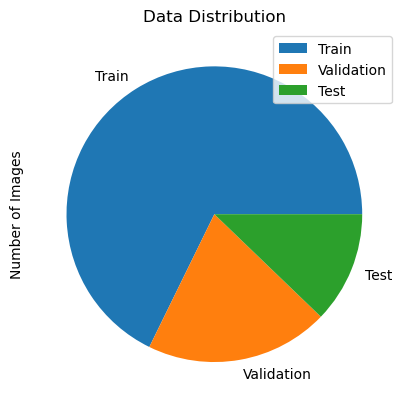

In [ ]:
plt.pie(
        [len(train_ids), len(val_ids), len(test_ids)],
        labels=['Train', 'Validation', 'Test'],
       )

plt.legend(loc='upper right')

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# Data Generator

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


print("Numero di batch nel training set:", len(training_generator))
print("Numero di batch nel validation set:", len(valid_generator))
print("Numero di batch nel test set:", len(test_generator))

Numero di batch nel training set: 250
Numero di batch nel validation set: 74
Numero di batch nel test set: 45


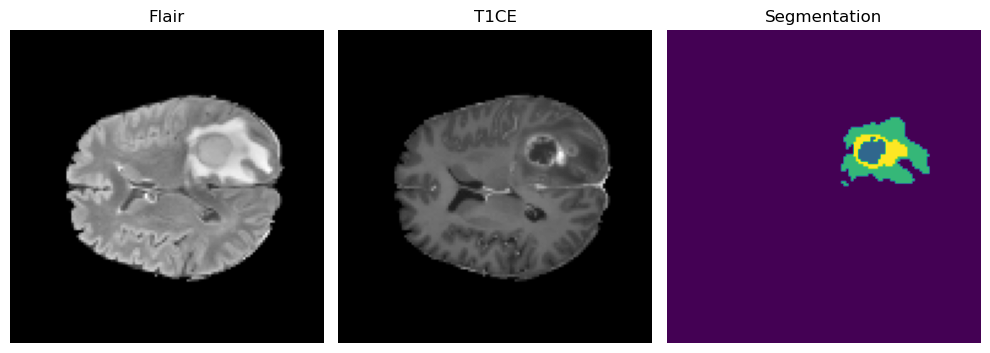

In [ ]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the ninth batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# Metrics

The pixel_accuracy function calculates the percentage of correctly classified pixels in an image segmentation task. It compares the predicted class and the true class for each pixel and returns the overall mean accuracy.
However, this metric can be misleading in imbalanced datasets, where the background class is overrepresented since the model may achieve high accuracy by mostly predicting the background, while failing to correctly identify smaller but important regions like tumors.

In [ ]:
#The pixel_accuracy function calculates the percentage of correctly classified pixels, 
#that is how many pixels the model predicted with the correct class out of the total number of pixels.
def pixel_accuracy(y_true, y_pred):
    y_true_labels = K.argmax(y_true, axis=-1)
    y_pred_labels = K.argmax(y_pred, axis=-1)
    matches = K.cast(K.equal(y_true_labels, y_pred_labels), dtype='float32')
    return K.mean(matches)

The mean_iou function calculates the Intersection over Union (IoU) for each of the 4 segmentation classes: no tumor, necrotic core, edema, and enhancing tumor. For each class, it computes the area of overlap between the predicted and ground truth masks divided by the area of their union, then returns the average IoU across all classes.

This metric is particularly useful in medical image segmentation tasks, as it accounts for both false positives and false negatives.

IoU = (Area of Overlap) / (Area of Union) = |A ∩ B| / |A ∪ B|

Where:
A is the predicted mask and B is the ground truth mask


The IoU loss is defined as:

IoU Loss = 1 − IoU

This motivates the network to enlarge the IoU in order to minimize the IoU loss.

In [ ]:
#The mean_iou function calculates the Intersection over Union (IoU) for each of the 4 classes (no tumor, necrotic, edema, enhancing), 
#and then returns the average IoU across all classes.
def mean_iou(y_true, y_pred, epsilon=1e-6):
    iou_scores = []
    for i in range(4):
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou)
    return K.mean(tf.stack(iou_scores))

The dice_coef function computes the average Dice coefficient across 4 segmentation classes. It measures the overlap between predicted and ground truth masks:

Dice = (2 x Area of overlapped) / (total Area)
 
Dice Loss = 1 − Dice Coefficient

This metric is very effective in medical image segmentation, where foreground regions (e.g., tumors) are small and imbalanced. Dice Loss gives more weight to overlapping areas, producing stronger gradients and encouraging the network to segment structures precisely, rather than defaulting to background predictions as can happen with IoU loss.

In [ ]:
# The function dice_coef calculates the average Dice coefficient across all 4 segmentation classes.
def dice_coef(y_true, y_pred, smooth=1.0):
    total_dice = 0
    for i in range(4):
        y_true_f = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_f = tf.reshape(y_pred[:, :, :, i], [-1])
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_dice += dice
    return total_dice / 4

Each class (necrotic, edema, enhancing) represents a distinct tissue type with different clinical relevance.
By computing the Dice score separately, we can better understand how well the model segments each region, rather than relying only on an average result.

In [ ]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon) 


The sensitivity function (also known as recall or true positive rate) computes how well the model detects positive pixels for each tumor class (necrotic, edema, enhancing). It ignores class 0 (background) and returns the average sensitivity across the 3 tumor regions.

In [ ]:
def sensitivity(y_true, y_pred, epsilon=1e-6):
    sensitivities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true_c * (1 - y_pred_c), 0, 1)))
        recall = tp / (tp + fn + epsilon)
        sensitivities.append(recall)
    return K.mean(tf.stack(sensitivities))


The precision function computes the positive predictive value for each tumor class,  measuring the proportion of predicted positive pixels that are actually positive and ignoring the background class (0). It returns the average precision across the 3 tumor regions. 

In [ ]:
def precision(y_true, y_pred, epsilon=1e-6):
    precisions = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        prec = tp / (tp + fp + epsilon)
        precisions.append(prec)
    return K.mean(tf.stack(precisions))

The specificity function calculates the true negative rate for each tumor class, measuring the proportion of negative ground truth pixels correctly predicted as negative and ignoring the background class (0). It returns the average specificity across the 3 tumor regions.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def specificity(y_true, y_pred, epsilon=1e-6):
    specificities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        
        tn = K.sum(K.round(K.clip((1 - y_true_c) * (1 - y_pred_c), 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        
        spec = tn / (tn + fp + epsilon)
        specificities.append(spec)
    
    return K.mean(tf.stack(specificities))


# Define the Model

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

In [ ]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_{epoch:02d}-{val_loss:.6f}.weights.h5', 
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('training.log', separator=',', append=False)
    ]

Code for training the model:


K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

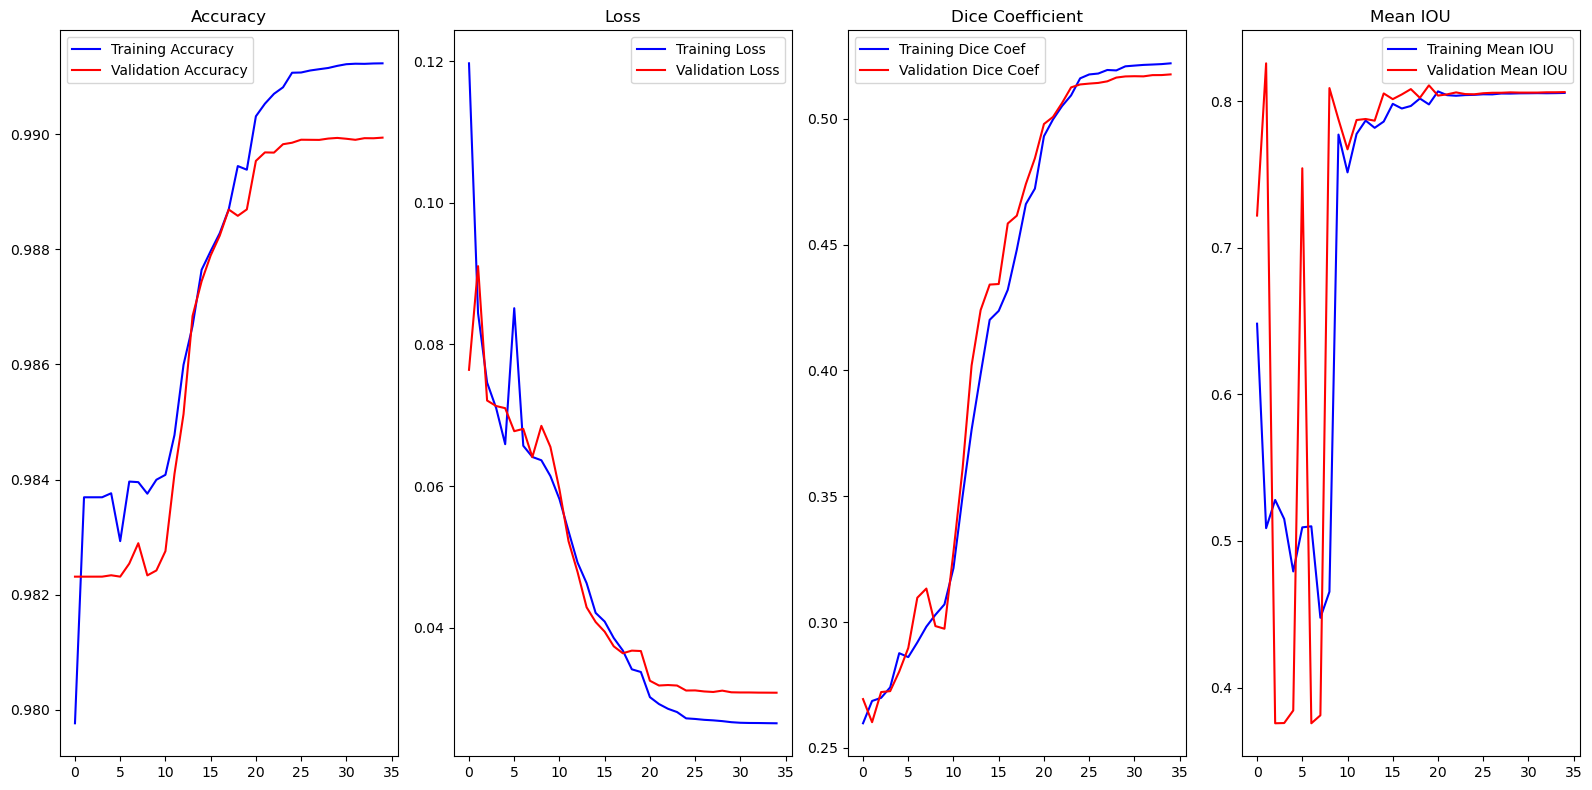

In [ ]:
history = pd.read_csv('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/training.log', sep=',', engine='python')
#history = pd.read_csv('C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/training.log', sep=',', engine='python')

hist = history

acc = hist['accuracy']
val_acc = hist['val_accuracy']

epoch = range(len(acc))

loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IOU')
ax[3].legend()
ax[3].set_title('Mean IOU')

plt.tight_layout()
plt.show()

# Predict Tumor Segmentations

In [ ]:
# Trova l'indice dell'epoca migliore in base a val_loss
best_epoch_idx = history['val_loss'].idxmin()

# Estrai i dati dell'epoca migliore
best_epoch = history.iloc[best_epoch_idx]
print(f"Migliore epoca: {int(best_epoch['epoch'])} con val_loss: {best_epoch['val_loss']:.6f}")

Migliore epoca: 34 con val_loss: 0.030809


In [ ]:
# Parametri
IMG_SIZE = 128

# Trova l'epoca migliore in automatico
best_epoch_idx = history['val_loss'].idxmin()
best_epoch = history.iloc[best_epoch_idx]
epoch_num = int(best_epoch['epoch'])
val_loss = best_epoch['val_loss']
print(f"Loading best model weights from epoch {epoch_num} with val_loss {val_loss:.6f}")

# Costruisci e compila il modello
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef, precision, sensitivity, specificity,
        dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
    ]
)

# Carica i pesi migliori
model.load_weights('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/model_34-0.030816.weights.h5')

Loading best model weights from epoch 34 with val_loss 0.030809


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [ ]:
def predictByPath(case_path, case):
    # Costruisci il modello
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet(input_layer, 'he_normal', 0.2)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef, precision, sensitivity, specificity,
            dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
        ]
    )

    # Carica i pesi migliori dal file
    model.load_weights('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/model_34-0.030816.weights.h5')

    # Prepara i dati di input
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce    = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalizza e predici
    return model.predict(X / np.max(X), verbose=1)

In [ ]:
# Funzione di base per il plotting SENZA SLIDER
def plot_prediction_slices(p, gt, origImage, slice_idx):
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    fig, axarr = plt.subplots(1, 6, figsize=(24, 6))

    background = cv2.resize(origImage[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    axarr[0].imshow(background, cmap="gray")
    axarr[0].set_title('Original FLAIR')

    gt_slice = cv2.resize(gt[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(background, cmap="gray")
    axarr[1].imshow(gt_slice, cmap="turbo", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground Truth')

    prediction_all = p[slice_idx, :, :, 1:4]
    axarr[2].imshow(background, cmap="gray")
    axarr[2].imshow(np.sum(prediction_all, axis=-1), cmap="turbo", interpolation='none', alpha=0.3)
    axarr[2].set_title('All Classes Predicted')

    axarr[3].imshow(background, cmap="gray")
    axarr[3].imshow(edema[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[2]} Predicted')

    axarr[4].imshow(background, cmap="gray")
    axarr[4].imshow(core[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[1]} Predicted')

    axarr[5].imshow(background, cmap="gray")
    axarr[5].imshow(enhancing[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} Predicted')

    for ax in axarr:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Funzione per un caso (visualizzazione statica)
def showPredictsById(case_number, slice_idx=60):
    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    plot_prediction_slices(p, gt, origImage, slice_idx)

# Funzione per un caso (interattivo con slider)
def interactiveShowPredictsById(case_number):
    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    def plot_wrapper(slice_idx):
        plot_prediction_slices(p, gt, origImage, slice_idx)

    slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES-1, step=1, description='Slice:')
    widgets.interact(plot_wrapper, slice_idx=slider)

# Funzione per visualizzare più casi in sequenza
def showMultiplePredictsByIds(case_numbers, slice_idx=60):
    for case_number in case_numbers:
        print(f"=== Case {case_number} ===")
        showPredictsById(case_number, slice_idx)

=== Case 196 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step


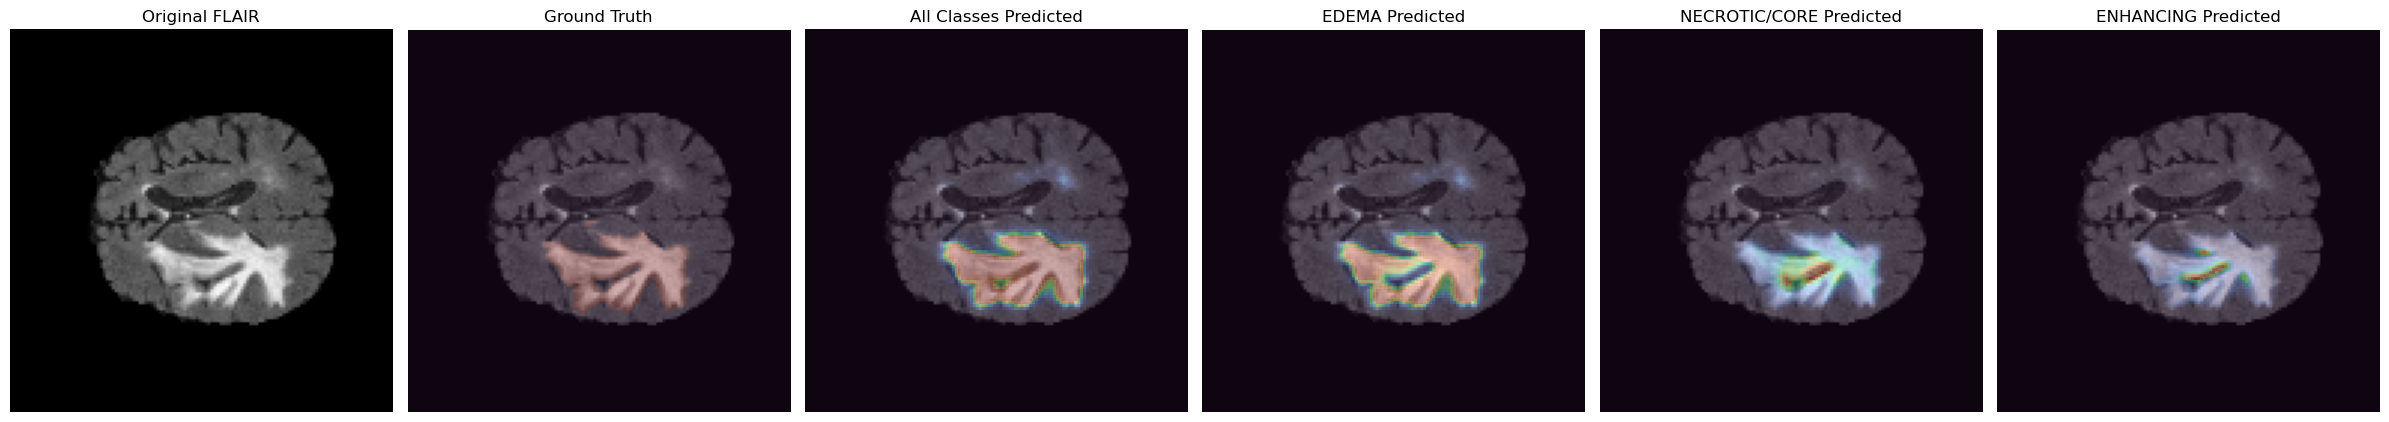

=== Case 132 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step


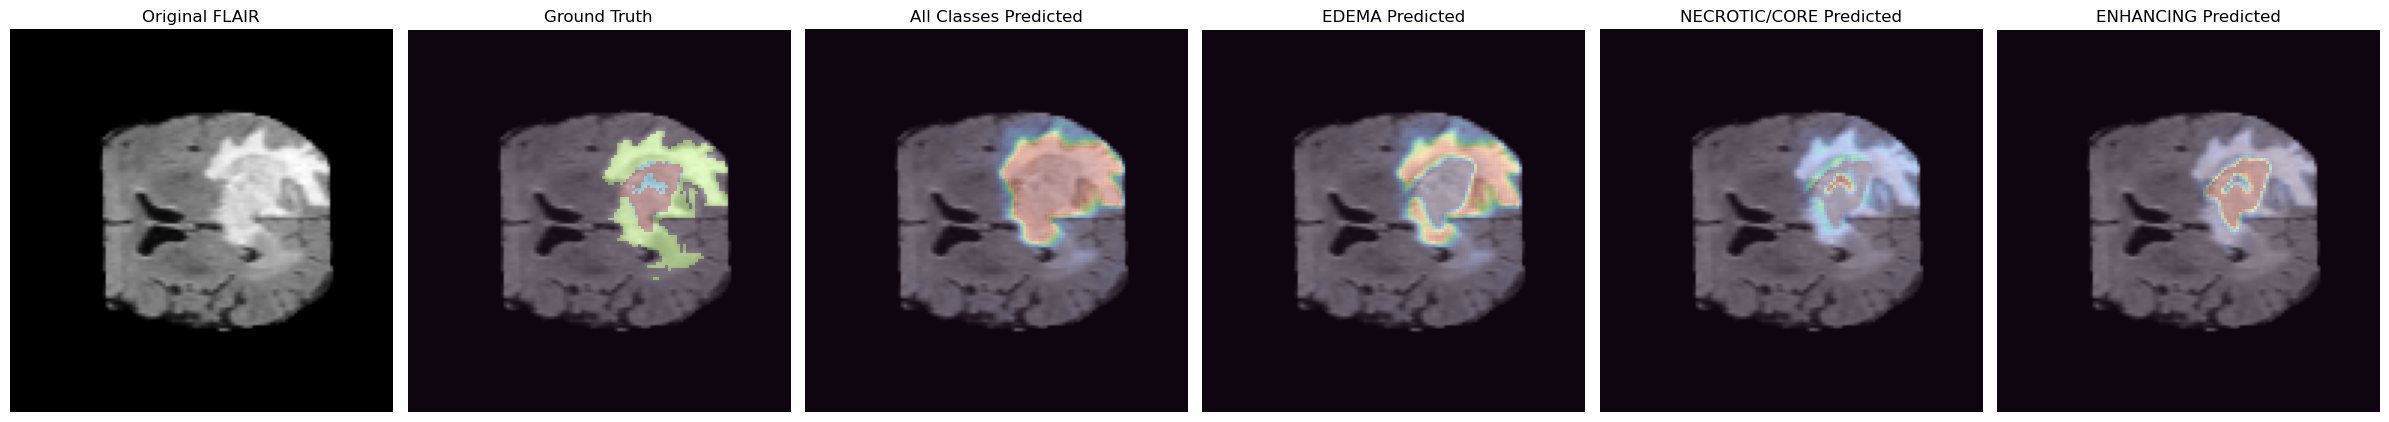

=== Case 306 ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step


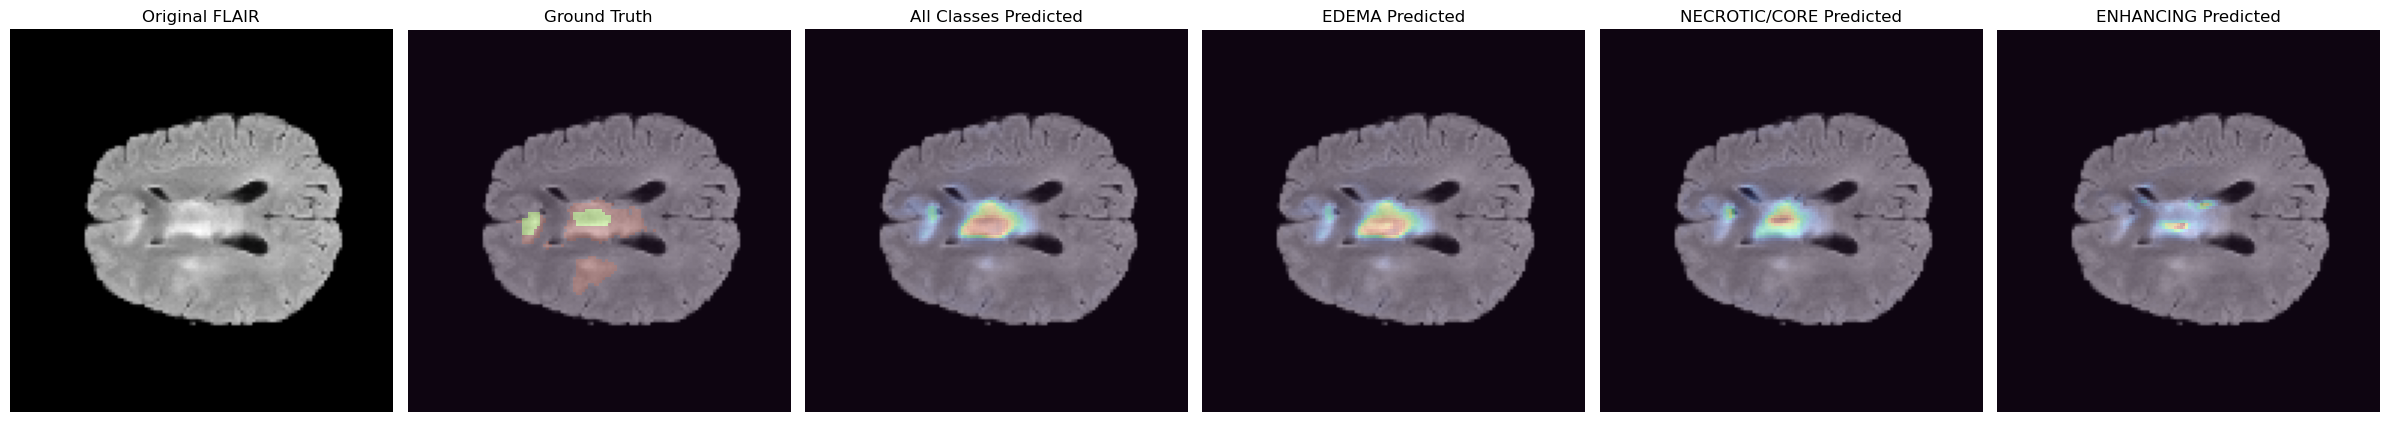

In [ ]:
# Estrai ultimi 3 caratteri da ogni ID
case_numbers = [id[-3:] for id in test_ids[:3]]

# Visualizza in sequenza il slice 60 per ciascuno
showMultiplePredictsByIds(case_numbers, slice_idx=60)

In [ ]:
#Visualizzazione con slider

def interactiveShowMultipleCasesSynced(case_numbers):
    all_data = []
    for case_number in case_numbers:
        case_id = f"BraTS20_Training_{case_number}"
        path = os.path.join(TRAIN_DATASET_PATH, case_id)

        gt_path = os.path.join(path, f"{case_id}_seg.nii")
        flair_path = os.path.join(path, f"{case_id}_flair.nii")

        gt = nib.load(gt_path).get_fdata()
        origImage = nib.load(flair_path).get_fdata()
        p = predictByPath(path, case_number)

        all_data.append((case_number, p, gt, origImage))

    def plot_all_cases(slice_idx):
        n = len(all_data)
        fig, axs = plt.subplots(n, 6, figsize=(24, 6 * n))
        axs = np.atleast_2d(axs)  # forza axs ad avere sempre forma (n, 6)
 


        for i, (case_number, p, gt, origImage) in enumerate(all_data):
            
                 
            core = p[:, :, :, 1]
            edema = p[:, :, :, 2]
            enhancing = p[:, :, :, 3]

            # Estrai la slice una volta sola e ridimensiona
            flair_slice = origImage[:, :, slice_idx + VOLUME_START_AT]
            flair_resized = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))

            gt_slice = gt[:, :, slice_idx + VOLUME_START_AT]
            gt_resized = cv2.resize(gt_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            pred_all = np.sum(p[slice_idx, :, :, 1:4], axis=-1)
            pred_all_resized = cv2.resize(pred_all, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            edema_resized = cv2.resize(edema[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            core_resized = cv2.resize(core[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            enh_resized = cv2.resize(enhancing[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            axs[i, 0].imshow(flair_resized, cmap="gray")
            axs[i, 0].set_title(f'{case_number} - FLAIR')

            axs[i, 1].imshow(flair_resized, cmap="gray")
            axs[i, 1].imshow(gt_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 1].set_title('Ground Truth')

            axs[i, 2].imshow(flair_resized, cmap="gray")
            axs[i, 2].imshow(pred_all_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 2].set_title('All Predicted')

            axs[i, 3].imshow(flair_resized, cmap="gray")
            axs[i, 3].imshow(edema_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 3].set_title(f'{SEGMENT_CLASSES[2]}')

            axs[i, 4].imshow(flair_resized, cmap="gray")
            axs[i, 4].imshow(core_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 4].set_title(f'{SEGMENT_CLASSES[1]}')

            axs[i, 5].imshow(flair_resized, cmap="gray")
            axs[i, 5].imshow(enh_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 5].set_title(f'{SEGMENT_CLASSES[3]}')
        
            for ax in axs[i]:
                ax.axis('off')
            

        plt.tight_layout()
        plt.show()
        plt.close(fig)

    slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES - 1, step=1, description='Slice:')
    out = widgets.interactive_output(plot_all_cases, {'slice_idx': slider})
    display(widgets.VBox([slider, out]))

In [ ]:
case_numbers = [id[-3:] for id in test_ids[:3]]
interactiveShowMultipleCasesSynced(case_numbers)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step


In [ ]:
def interactiveComparePredGtHorizontal(case_number):

    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    classes = {
        'Core': 1,
        'Edema': 2,
        'Enhancing': 3
    }


    def plot_slice(slice_idx, show_gt, show_pred, show_errors, show_core, show_edema, show_enhancing):

        background = cv2.resize(origImage[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        gt_slice = cv2.resize(gt[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        pred_probs = p[slice_idx, :, :, 1:4]
        pred_bin = (pred_probs > 0.5).astype(np.uint8)

        selected_classes = []
        if show_core:
            selected_classes.append('Core')
        if show_edema:
            selected_classes.append('Edema')
        if show_enhancing:
            selected_classes.append('Enhancing')

        fig, ax = plt.subplots(figsize=(4, 4))
    
        ax.imshow(background, cmap='gray')

        combined_overlay = np.zeros(background.shape + (4,))  # RGBA overlay

        if show_gt:
            for cls_name in selected_classes:
                mask = (gt_slice == classes[cls_name])
                color = np.zeros(4)
                if cls_name == 'Core': color = [1, 0, 0, 0.3]
                elif cls_name == 'Edema': color = [0, 1, 0, 0.3]
                elif cls_name == 'Enhancing': color = [0, 0, 1, 0.3]
                overlay = np.zeros_like(combined_overlay)
                overlay[mask] = color
                combined_overlay = np.maximum(combined_overlay, overlay)

        if show_pred:
            for cls_name in selected_classes:
                cls_idx = classes[cls_name] - 1
                mask = (pred_bin[:, :, cls_idx] == 1)
                color = np.zeros(4)
                if cls_name == 'Core': color = [1, 0, 0, 0.5]
                elif cls_name == 'Edema': color = [0, 1, 0, 0.5]
                elif cls_name == 'Enhancing': color = [0, 0, 1, 0.5]
                overlay = np.zeros_like(combined_overlay)
                overlay[mask] = color
                combined_overlay = np.maximum(combined_overlay, overlay)

        if show_errors:
            gt_bin = (gt_slice > 0).astype(np.uint8)
            pred_bin_all = (np.sum(pred_bin, axis=2) > 0).astype(np.uint8)

            false_positive = np.logical_and(pred_bin_all == 1, gt_bin == 0)
            false_negative = np.logical_and(pred_bin_all == 0, gt_bin == 1)
            true_positive = np.logical_and(pred_bin_all == 1, gt_bin == 1)

            overlay_fp = np.zeros_like(combined_overlay)
            overlay_fp[false_positive] = [1, 0, 0, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_fp)

            overlay_fn = np.zeros_like(combined_overlay)
            overlay_fn[false_negative] = [0, 0, 1, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_fn)

            overlay_tp = np.zeros_like(combined_overlay)
            overlay_tp[true_positive] = [0, 1, 0, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_tp)

        ax.imshow(combined_overlay)

        ax.axis('off')
        ax.set_title(f"Slice {slice_idx} - GT and Prediction overlay")
        #plt.show()

    # Slider in una riga da solo
    slice_slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES-1, step=1, description='Slice', layout=widgets.Layout(width='80%'))

    # Checkboxes in una seconda riga compatta
    checkboxes = widgets.HBox([
        widgets.Checkbox(value=True, description='Show Ground Truth'),
        widgets.Checkbox(value=True, description='Show Prediction'),
        widgets.Checkbox(value=True, description='Show Error Map'),
        widgets.Checkbox(value=True, description='Core'),
        widgets.Checkbox(value=True, description='Edema'),
        widgets.Checkbox(value=True, description='Enhancing')
    ])

    # Recupero singoli checkbox per la funzione di callback
    show_gt = checkboxes.children[0]
    show_pred = checkboxes.children[1]
    show_errors = checkboxes.children[2]
    show_core = checkboxes.children[3]
    show_edema = checkboxes.children[4]
    show_enhancing = checkboxes.children[5]

    # Output della figura
    out = widgets.interactive_output(
        plot_slice,
        {
            'slice_idx': slice_slider,
            'show_gt': show_gt,
            'show_pred': show_pred,
            'show_errors': show_errors,
            'show_core': show_core,
            'show_edema': show_edema,
            'show_enhancing': show_enhancing
        }
    )

    display(slice_slider, checkboxes, out)

In [ ]:
interactiveComparePredGtHorizontal('196')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step


IntSlider(value=60, description='Slice', layout=Layout(width='80%'), max=99)

Output()

# Evaluation

45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9915 - dice_coef: 0.5393 - dice_coef_edema: 0.6848 - dice_coef_enhancing: 0.6457 - dice_coef_necrotic: 0.4126 - loss: 0.0276 - mean_io_u_14: 0.8060 - precision: 0.6841 - sensitivity: 0.4606 - specificity: 0.9993


,Metric,Value
0,Loss,0.0265
1,Accuracy,0.9919
2,Mean IoU,0.8053
3,Dice coefficient,0.5158
4,Precision,0.6434
5,Sensitivity,0.4250
6,Specificity,0.9993
7,Dice coef Necrotic,0.4065
8,Dice coef Edema,0.6512
9,Dice coef Enhancing,0.5884


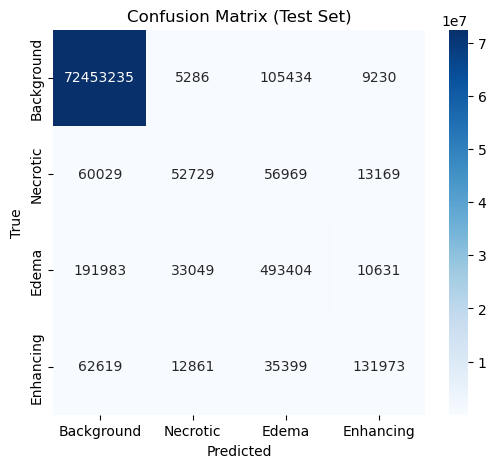

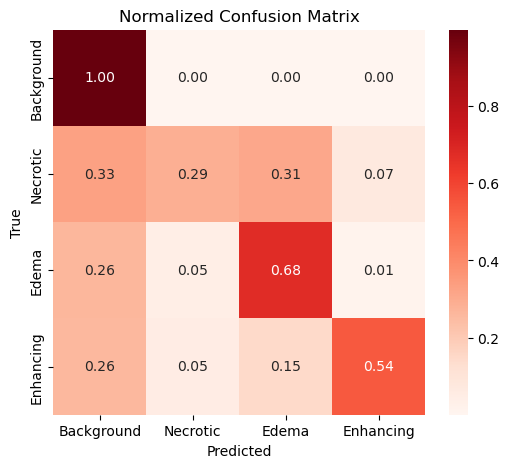

,Class,Precision,Recall,F1-score
0,Background,0.996,0.998,0.997
1,Necrotic,0.507,0.288,0.368
2,Edema,0.714,0.677,0.695
3,Enhancing,0.800,0.543,0.647


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === 1. EVALUATE MODEL ===
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)

descriptions = [
    "Loss",
    "Accuracy",
    "Mean IoU",
    "Dice coefficient",
    "Precision",
    "Sensitivity",
    "Specificity",
    "Dice coef Necrotic",
    "Dice coef Edema",
    "Dice coef Enhancing"
]

# Tabella riassuntiva metriche
eval_df = pd.DataFrame({
    "Metric": descriptions[:len(results)],
    "Value": [round(v, 4) for v in results[:len(results)]]
})
display(eval_df)

# === 2. CONFUSION MATRIX ===
y_true, y_pred = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    preds = model.predict(X_batch, verbose=0)
    preds = np.argmax(preds, axis=-1).flatten()
    true = np.argmax(y_batch, axis=-1).flatten()
    y_pred.extend(preds)
    y_true.extend(true)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])

# Plot confusion matrix assoluta
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Background","Necrotic","Edema","Enhancing"],
            yticklabels=["Background","Necrotic","Edema","Enhancing"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion matrix normalizzata (percentuali per classe)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=["Background","Necrotic","Edema","Enhancing"],
            yticklabels=["Background","Necrotic","Edema","Enhancing"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === 3. METRICHE DERIVATE PER CLASSE ===
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP

precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

metrics_per_class = pd.DataFrame({
    "Class": ["Background", "Necrotic", "Edema", "Enhancing"],
    "Precision": np.round(precision, 3),
    "Recall": np.round(recall, 3),
    "F1-score": np.round(f1, 3)
})
display(metrics_per_class)



# Mostra esempio
X_sample, y_sample = test_generator[0]
y_pred_sample = model.predict(X_sample)


TO DO LIST:
Hausdorff distance in the Metrics Section
Metrics on the K-Means result
Predict and Evaluation sections from Kaggle
